In [87]:
import lmdb
import numpy as np
import json
import cv2 
import caffe
from caffe.proto import caffe_pb2
from tqdm import tqdm_notebook
import scipy.io as scio
import os

# 生成TXT文件
格式为：/share1/home/chunyang/files/Dataset/Penn_Action/frames/0002/000001.jpg 00020001

In [113]:
train_lines = []
valid_lines = []
train_labels = []
valid_labels = []


label_root = '/share1/home/chunyang/files/Dataset/Penn_Action/labels'
frame_root = '/share1/home/chunyang/files/Dataset/Penn_Action/frames'
video_list = sorted(os.listdir(label_root))

for video in tqdm_notebook(video_list):
#video
    video_name = video[0:4]
    lable = scio.loadmat(os.path.join(label_root,video))
    jpg_list = sorted(os.listdir(os.path.join(frame_root,video_name)))
    
    for jpg_name in (jpg_list):
    #frame
        #line = os.path.join(video_name,jpg_name) + ' ' + video_name+jpg_name[2:6] +'\n'
        line = os.path.join(video_name,jpg_name)
        label = video_name+jpg_name[2:6]
        if lable['train'][0]==[1]:
            train_lines.append(line)
            train_labels.append(label)
        else:
            valid_lines.append(line)   
            valid_labels.append(label)

In [89]:
valid_txt = open('valid.txt','w')
for i_line in range(len(valid_lines)):
    valid_txt.writelines(valid_lines[i_line])
valid_txt.close()

train_txt = open('train.txt','w')
for i_line in range(len(train_lines)):
    train_txt.writelines(train_lines[i_line])
train_txt.close()

# 生成.npy文件对应于'4位vidoe_id + 4位image_id'标注

In [154]:
train = {}
valid = {}
for video in tqdm_notebook(video_list):
#video
    video_name = video[0:4]
    lable = scio.loadmat(os.path.join(label_root,video))
    # x ,y, visibility, bbox
    x = lable['x']
    y = lable['y']
    visibility = lable['visibility']
    bbox = lable['bbox']
    is_train = lable['train']
    jpg_list = sorted(os.listdir(os.path.join(frame_root,video_name)))
    
    if video_name in['1865']:
        #73--jpg , 72bbox
        bbox=np.row_stack((bbox,bbox[-1]))
        
    for i_jpg , jpg_name in enumerate(jpg_list):
        frame_id = video_name+jpg_name[2:6]
        
        if is_train==[1]:
            train[frame_id]=[]
            annotation = {}
            annotation['x']= x[i_jpg]
            annotation['y']= y[i_jpg]
            annotation['visibility']= visibility[i_jpg]
            annotation['bbox']= bbox[i_jpg]
            train[frame_id].append(annotation)
            
        else:
            valid[frame_id]=[]
            annotation = {}
            annotation['x']= x[i_jpg]
            annotation['y']= y[i_jpg]
            annotation['visibility']= visibility[i_jpg]
            annotation['bbox']= bbox[i_jpg]
            valid[frame_id].append(annotation)

In [155]:
print(valid['00010012'])
print(train['00020001'])

[{'x': array([130.5 , 134.25, 104.25, 154.5 , 141.  , 157.5 , 154.5 , 111.  ,
       105.75, 135.75, 102.  , 119.25,  91.5 ]), 'y': array([ 69.75, 102.75,  96.  , 144.  , 148.5 , 111.  , 122.25, 168.75,
       178.5 , 255.  , 254.25, 322.5 , 316.5 ]), 'visibility': array([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1], dtype=uint8), 'bbox': array([ 84.75,  44.25, 164.25, 348.  ])}]
[{'x': array([48.        , 25.33333333, 68.        , 36.        , 83.33333333,
       64.66666667, 81.33333333, 36.        , 67.33333333, 48.66666667,
       67.33333333, 28.        , 69.33333333]), 'y': array([ 52.        ,  80.66666667,  72.66666667, 106.        ,
       108.        ,  81.33333333,  81.33333333, 140.        ,
       150.        , 202.        , 200.        , 260.        ,
       247.33333333]), 'visibility': array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8), 'bbox': array([ 19.33333333,  31.33333333,  89.33333333, 269.33333333])}]


In [156]:
np.save('valid.npy',valid)
np.save('train.npy',train)

# 生成LMDB文件

In [118]:
#basic setting
train_lmdb_file = 'train.lmdb'
valid_lmdb_file = 'valid.lmdb'
batch_size = 256
in_db = lmdb.open(train_lmdb_file, map_size=int(1e12)) 
with in_db.begin(write=True) as in_txn: # 创建操作数据库句柄
    for in_idx, img_path in enumerate(tqdm_notebook(train_lines)):
        fn = os.path.join(frame_root,img_path)
        with open(fn, 'rb') as f:
            img_data = f.read()
            in_txn.put(img_path.encode('ascii'), img_data)
in_db.close()

In [119]:
in_db = lmdb.open(valid_lmdb_file, map_size=int(1e12)) 
with in_db.begin(write=True) as in_txn: # 创建操作数据库句柄
    for in_idx, img_path in enumerate(tqdm_notebook(valid_lines)):
        fn = os.path.join(frame_root,img_path)
        with open(fn, 'rb') as f:
            img_data = f.read()
            in_txn.put(img_path.encode('ascii'), img_data)
in_db.close()

# 读LMDB 文件

In [131]:
import six
from PIL import Image
import matplotlib.pyplot as plt

In [141]:
print(valid_lines[0])

0001/000001.jpg


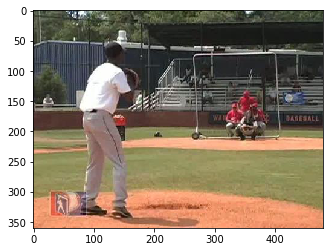

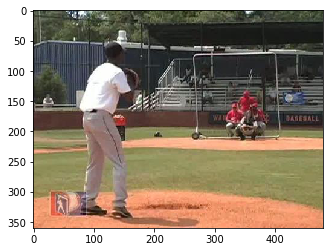

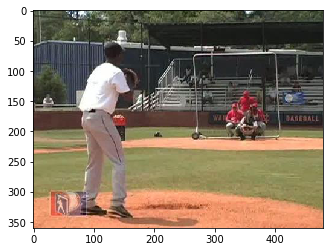

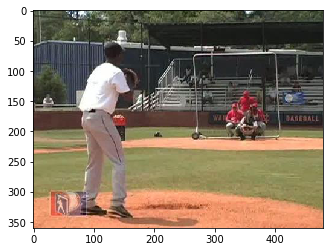

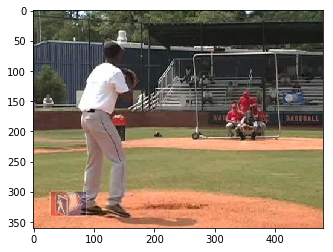

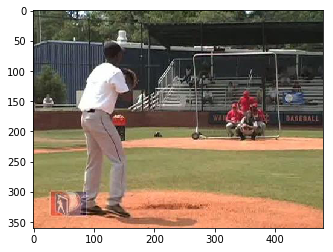

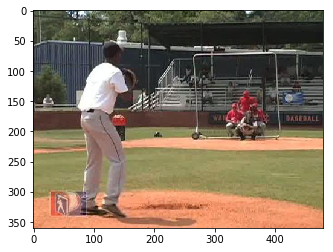

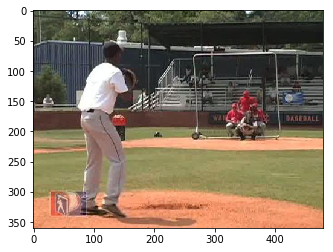

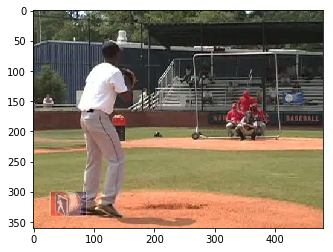

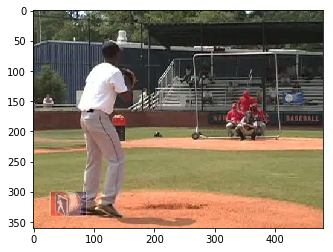

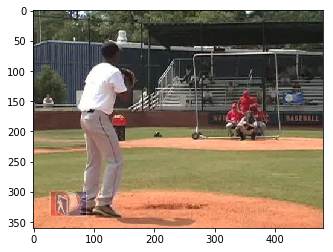

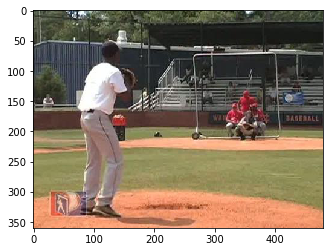

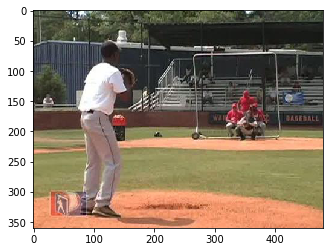

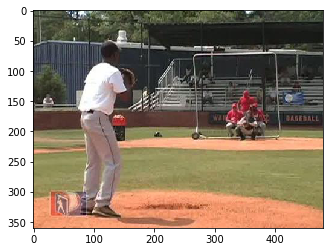

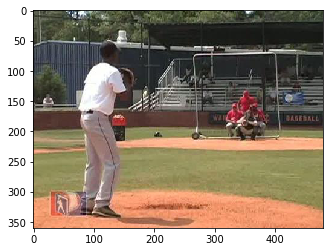

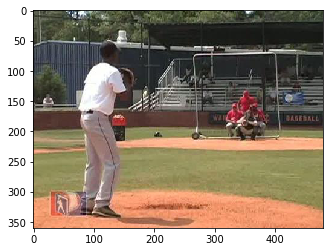

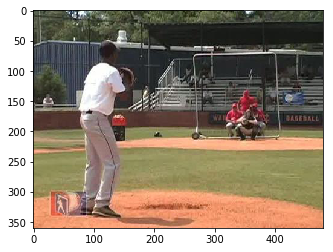

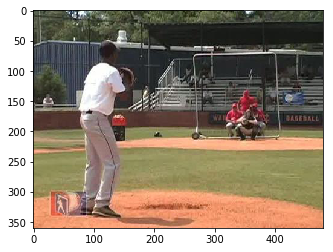

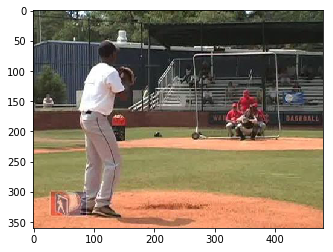

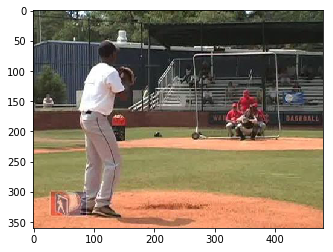

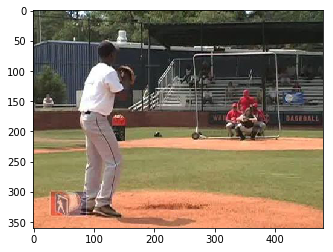

KeyboardInterrupt: 

In [162]:
env = lmdb.open('valid.lmdb',max_readers=1,readonly=True,lock=False,readahead=False,meminit=False)
with env.begin(write=False) as txn:
    for in_idx, img_path in enumerate(tqdm_notebook(valid_lines)):
        imgbuf = txn.get(img_path.encode())
        buf = six.BytesIO()
        buf.write(imgbuf)
        img = Image.open(buf).convert('RGB')
        plt.imshow(img)
        plt.show()

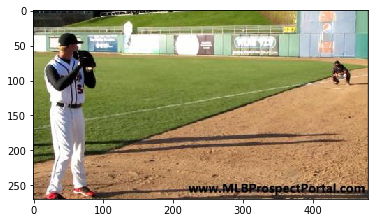

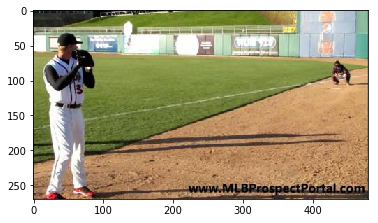

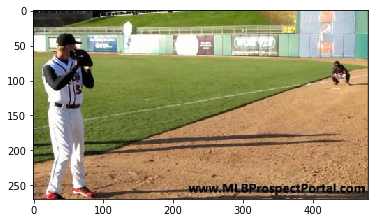

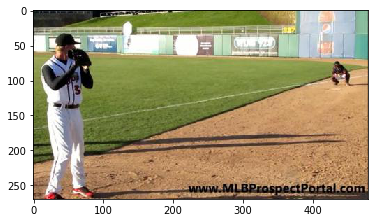

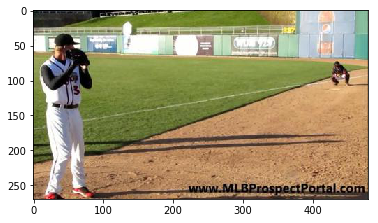

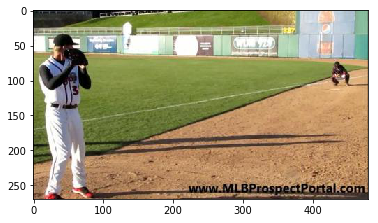

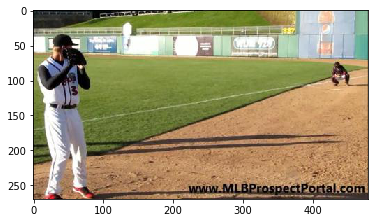

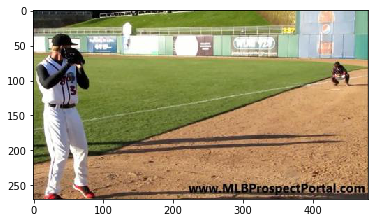

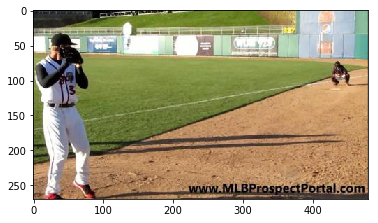

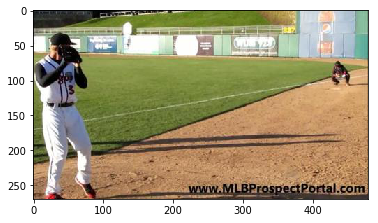

KeyboardInterrupt: 

In [138]:
env = lmdb.open('train.lmdb',max_readers=1,readonly=True,lock=False,readahead=False,meminit=False)
with env.begin(write=False) as txn:
    for in_idx, img_path in enumerate(tqdm_notebook(train_lines)):
        imgbuf = txn.get(img_path.encode())
        buf = six.BytesIO()
        buf.write(imgbuf)
        img = Image.open(buf).convert('RGB')
        plt.imshow(img)
        plt.show()